## Time Series Analysis and Prediction
* predicting the consumption of electricity in the coming future
* Time series analysis accounts for the fact that data points taken over time may have an internal structure (such as auto-correlation, trend or seasonal variation) that should be accounted for.

https://www.kaggle.com/datasets/kandij/electric-production

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams
# set plot size
rcParams['figure.figsize'] = 10, 6
# read data
folder_path = '/content/drive/MyDrive/ETE_projects/time_series/'
df = pd.read_csv(folder_path+ 'Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def visualization(data):
  print(data.info())
  print('-------------------------------------------------------')
  print(data.shape)
  print('-------------------------------------------------------')
  print(data.isnull().sum())

visualization(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB
None
-------------------------------------------------------
(397, 2)
-------------------------------------------------------
DATE          0
IPG2211A2N    0
dtype: int64


In [ ]:
df['DATE'] = pd.to_datetime(df.DATE)
# df.reset_index(inplace = True)
df = df.set_index(df.DATE)
df.drop('DATE', axis=1, inplace=True)
print(df.dtypes)
df.head()

IPG2211A2N    float64
dtype: object


,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.tail(3)

,IPG2211A2N
DATE,
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [ ]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


### Visualize the Data

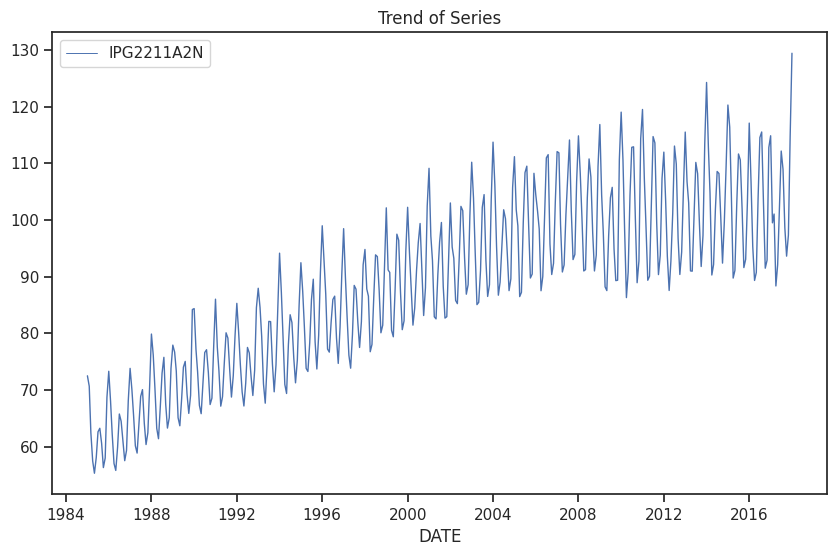

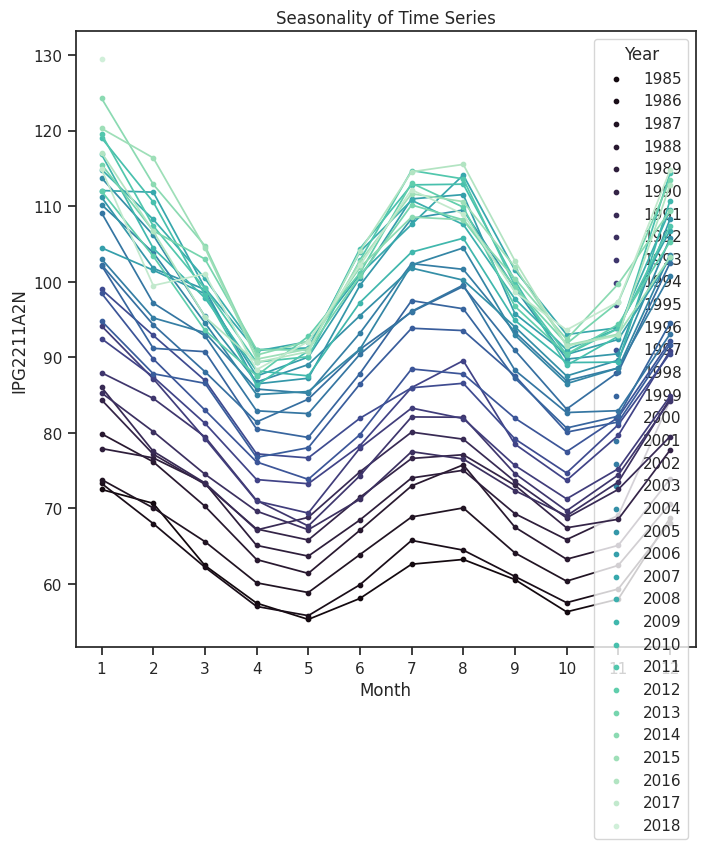

In [ ]:
## Time series Characteristics
def characteristics(data, x, y, title):
  ax = sns.lineplot(data = data, lw=1)
  ax.lines[0].set_linestyle('solid')
  ax.set_title(title)

  df_temp = data.copy()
  df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
  df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
  # Stacked Line Plot
  plt.figure(figsize=(8,8))
  plt.title('Seasonality of Time Series')
  sns.set(style="ticks", rc={"lines.linewidth": 0.7})
  sns.pointplot(x='Month', y= 'IPG2211A2N', hue='Year', data = df_temp,palette='mako', linestyles='-' )

characteristics(df, 'DATE', 'IPG2211A2N','Trend of Series')

<pre>
- We observe upward trend the graph.
- There is also slight increase in the variance over time.
- We also observe that the data is seasonal and there is dip during April-May(4-5) and rise during July-August(7-8) and November- December(11-12)

### Check for Stationarity

In [ ]:
sns.set_style('whitegrid')
col = 'IPG2211A2N'
def stationarity_test(data, window, title, col_name):
  data['r_mean'] = data[col_name].rolling(window = window).mean()
  data['r_std'] = data[col_name].rolling(window=window).std()
  # Plot rolling statistic
  ax = sns.lineplot(data = data, lw=1, palette=['navy', 'darkgreen', 'red'])
  ax.lines[0].set_linestyle('solid')
  ax.set_title(title)
  # Dickey Fuller test
  df_test = adfuller(data[col_name])
  df_output = pd.Series(df_test[0:4], index=['Test Statistic',
                                             'p-value',
                                             'Lags used for t-statistic',
                                             'No_of_observation_used'])
  for key, value in df_test[4].items():
    df_output['Critical value(%s)'%key] = value
  print(df_output)

Test Statistic                -2.256990
p-value                        0.186215
Lags used for t-statistic     15.000000
No_of_observation_used       381.000000
Critical value(1%)            -3.447631
Critical value(5%)            -2.869156
Critical value(10%)           -2.570827
dtype: float64


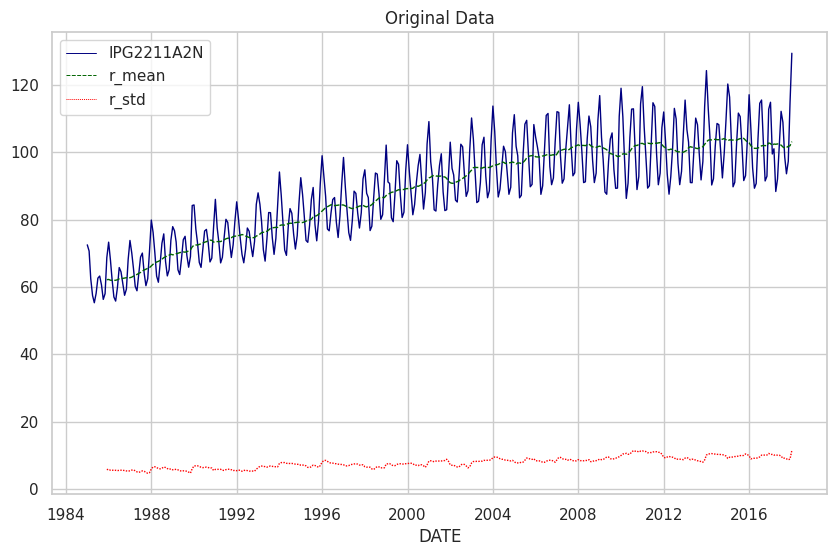

In [ ]:
stationarity_test(df, 12, 'Original Data',col)

<pre>
<b>Rolling Statistics</b>:
Standard deviation has less variation but mean is increasing continuously.
<b>Critical Value  -2.256990 </b>: Critical value of the data
<b>p-value  0.186215</b>: Probability that null hypothesis will not be rejected.
<b>t-statistic_Lag 15.000000</b>: Number of lags used in regression to determine t-statistic. So there are no auto correlations going back to '0' periods here.
No_of_observation_used  381.000000 : Number of observations used in the analysis.

Critical value(1%)            -3.447631
Critical value(5%)            -2.869156
Critical value(10%)           -2.570827

T values corresponding to adfuller test.
Since critical value -2.25>-3.44,-2.86,-2.57 (t-values at 1%,5%and 10% confidence intervals), null hypothesis cannot be rejected.
So there is non stationarity in the data.
Also p-value of 0.18>0.05(if we take 5% significance level or 95% confidence interval), null hypothesis is accepted.
Hence data is non stationary (that means it has relation with time)
</pre>


Test Statistic              -7.104891e+00
p-value                      4.077787e-10
Lags used for t-statistic    1.400000e+01
No_of_observation_used       3.810000e+02
Critical value(1%)          -3.447631e+00
Critical value(5%)          -2.869156e+00
Critical value(10%)         -2.570827e+00
dtype: float64


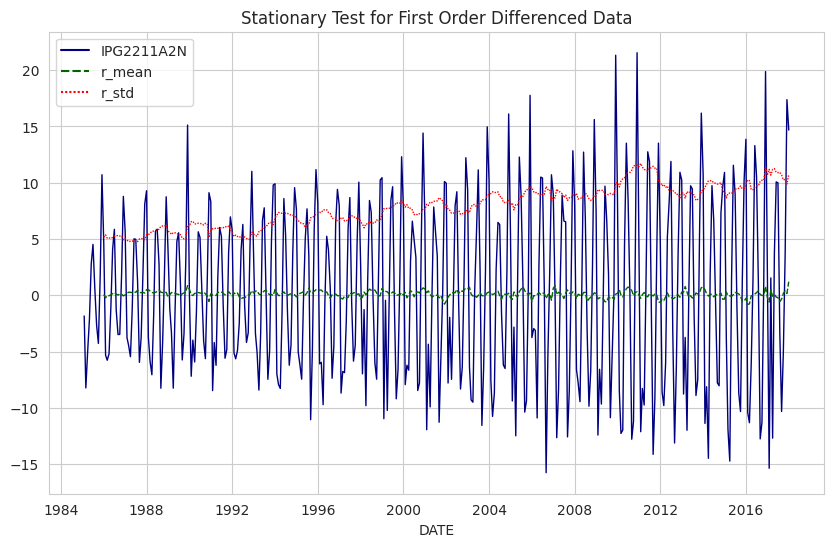

In [ ]:
## Converting Non-Stationary Data into Stationary Data
# Differencing

def differencing(data,order):
  df_diff = data.diff(periods=order)
  # Data transformation may add na values
  df_diff.dropna(inplace=True)
  return df_diff

df_diff = differencing(df, 1)
stationarity_test(df_diff,12, 'Stationary Test for First Order Differenced Data',col )

* There is slight upward trend in standard deviation.
* Test statistic Value is less than (1%, 5%, 10%) critical.
* p-value is lesser than 0.05.
Thus it is stationary series.
* There is variance along with time

### Log Transformation

variation proportional to the levels log transformation.

Test Statistic                -3.145360
p-value                        0.023373
Lags used for t-statistic     15.000000
No_of_observation_used       381.000000
Critical value(1%)            -3.447631
Critical value(5%)            -2.869156
Critical value(10%)           -2.570827
dtype: float64


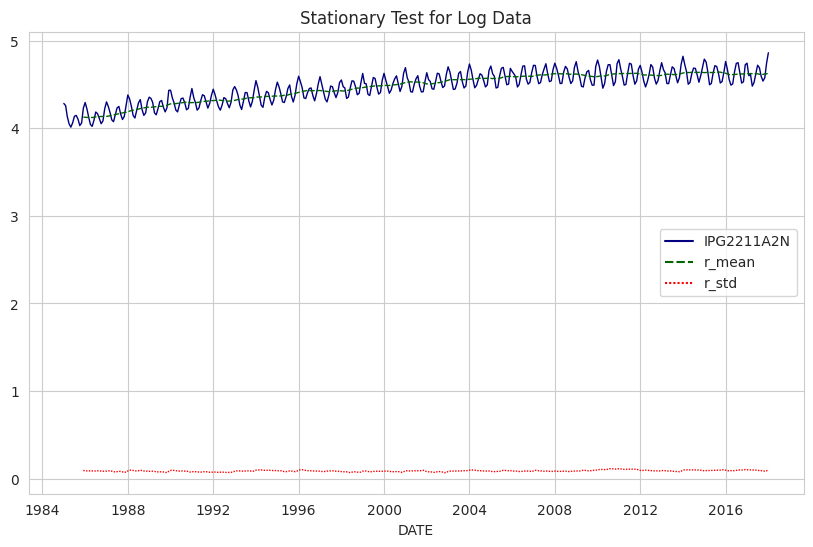

In [ ]:
df_log = np.log(df)
stationarity_test(df_log,12, 'Stationary Test for Log Data',col )

In [ ]:
# Using transformation because there is variance.
# variation proportional to the levels. Hence use log transformation

Test Statistic              -6.654626e+00
p-value                      5.020330e-09
Lags used for t-statistic    1.400000e+01
No_of_observation_used       3.700000e+02
Critical value(1%)          -3.448148e+00
Critical value(5%)          -2.869383e+00
Critical value(10%)         -2.570948e+00
dtype: float64


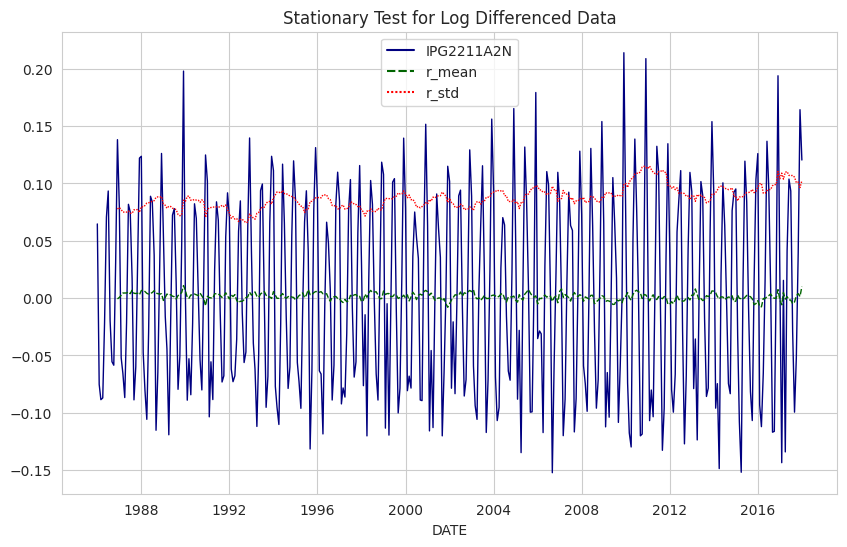

In [ ]:
# First order differencing
df_log_diff = differencing(df_log, 1)
stationarity_test(df_log_diff,12,'Stationary Test for Log Differenced Data',col)

In [ ]:
# test statisitc < critical values  = stationary

### Forecasting

#### Auto Rergressive Model

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
df_log_diff

,IPG2211A2N,r_mean,r_std
DATE,,,
1986-01-01,0.064678,NaN,NaN
1986-02-01,-0.075323,NaN,NaN
1986-03-01,-0.088605,NaN,NaN
1986-04-01,-0.087082,NaN,NaN
1986-05-01,-0.021609,NaN,NaN
...,...,...,...
2017-09-01,-0.099489,-0.003434,0.105466
2017-10-01,-0.052051,0.001915,0.100747
2017-11-01,0.038991,0.003896,0.101265


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


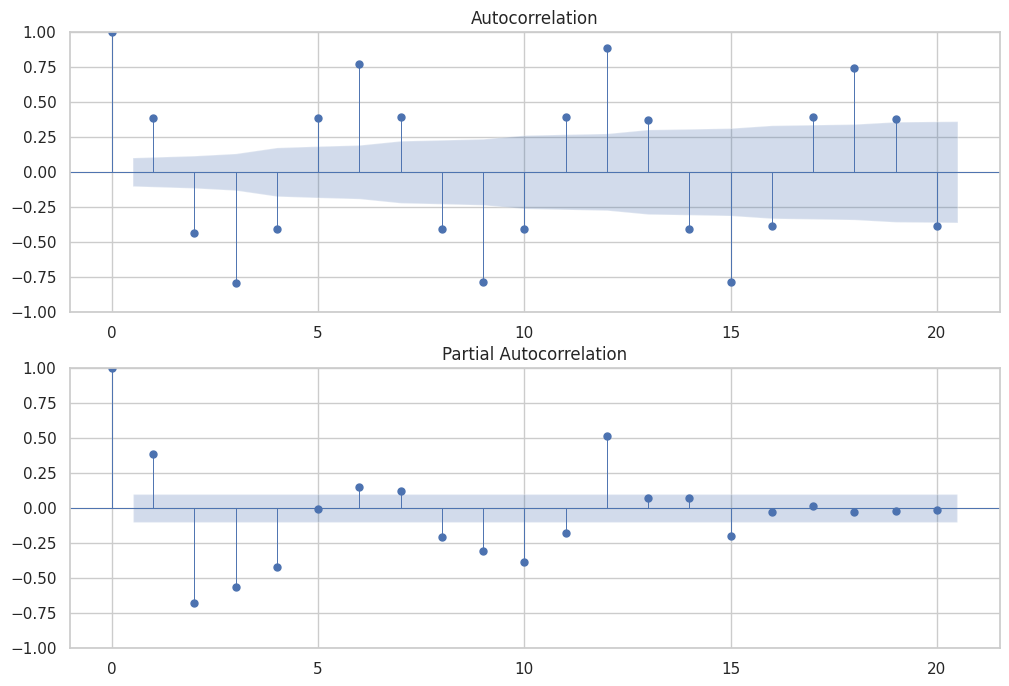

In [ ]:
# acf to see if there is direct impact or indirect impact
# finding q :
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_log_diff[col].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_log_diff[col].iloc[13:],lags=20,ax=ax2)

https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

In [ ]:
# q=3(significant lag at 3 and not beyond) p=2,3, 4

### Finding PQD order for sarimax is the seasonal component

<pre>
Let's now use the decomposition technique to
deconstruct the time series data into several component like trend and seasonality for
visualization of time series characteristics.

We have used 'additive' model
 because it is quick to develop, fast to
 train, and provide interpretable patterns.
</pre>

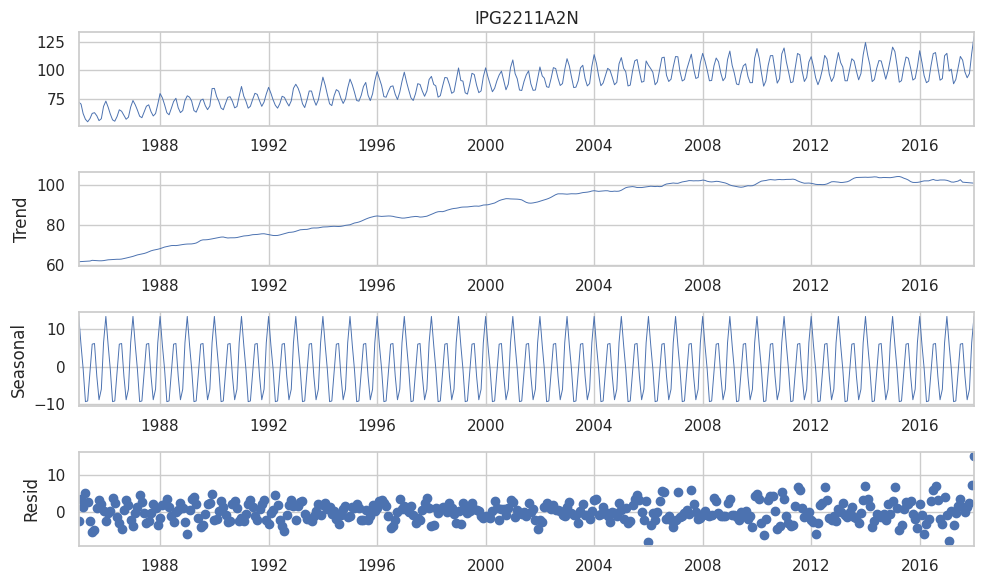

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[col], model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

* In order to evaluate the seasonal order, we must extract the seasonal component from the time series.
* In order to extract D, we have to check whether the seasonal componenet is stationary or not.

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


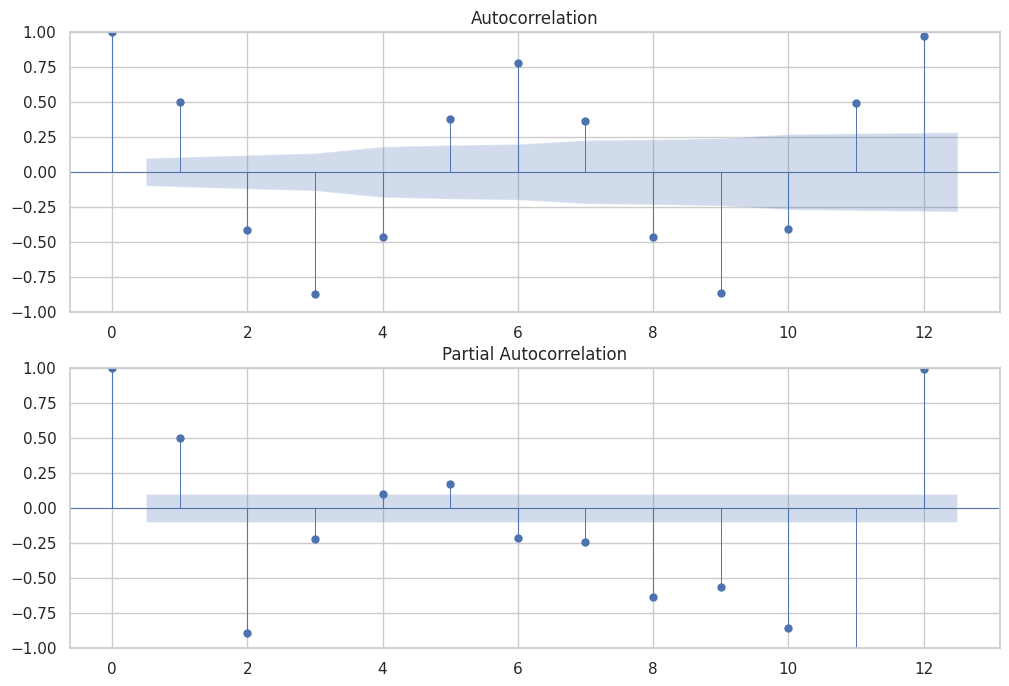

In [ ]:
# P , Q order
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal,lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal,lags=12,ax=ax2)

In [ ]:
# D=0, Q=12, P= 11 (p,d,q), (P)
# q=3(significant lag at 3 and not beyond) p=2,3, 4

In [ ]:
# Split time series: train and test test
df_train = df_log[:278]
df_test = df_log[279:]

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_train['IPG2211A2N'],order=(4,1,3), seasonal_order = (10, 0, 12,12))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
df_a = df_log.copy(deep=True)

In [ ]:
pred= results.predict(start = df_test.index[0], end = df_test.index[-1])

In [ ]:
df_test['pred_h'] = pred.values

<ipython-input-25-c70a37c4acd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_h'] = pred.values


<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

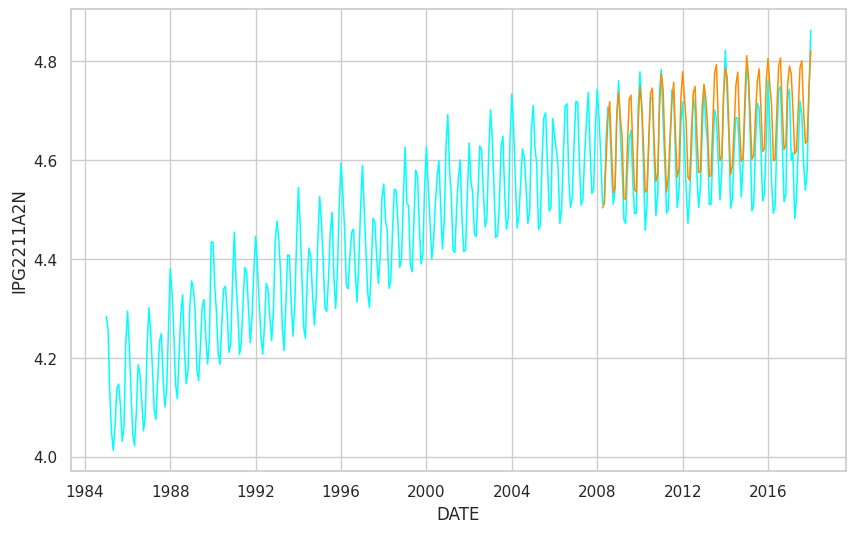

In [ ]:
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred', color='darkorange', lw=1.1)

<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

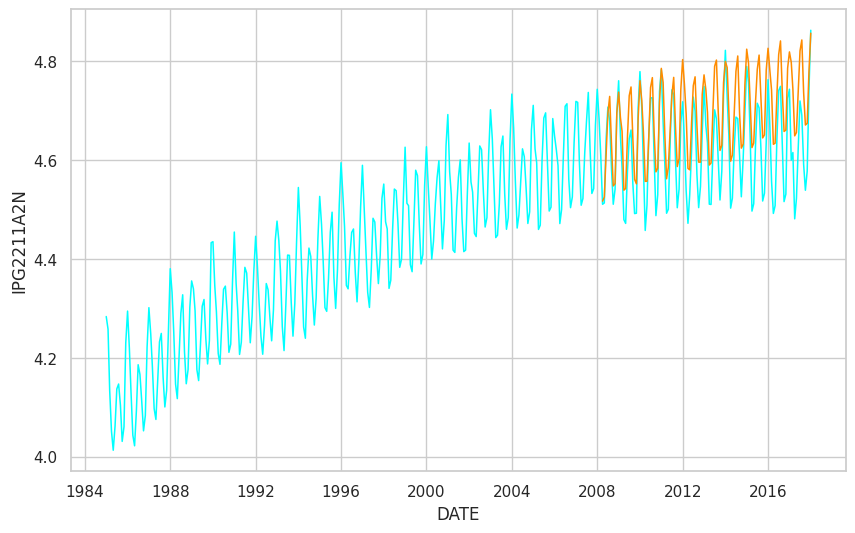

In [ ]:
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred_a', color='darkorange', lw=1.1)

<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

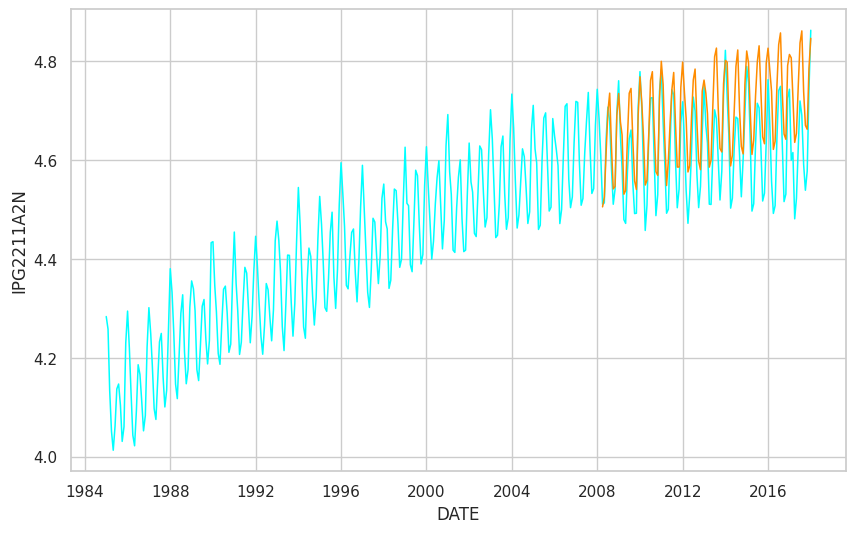

In [ ]:
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred_b', color='darkorange', lw=1.1)

<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

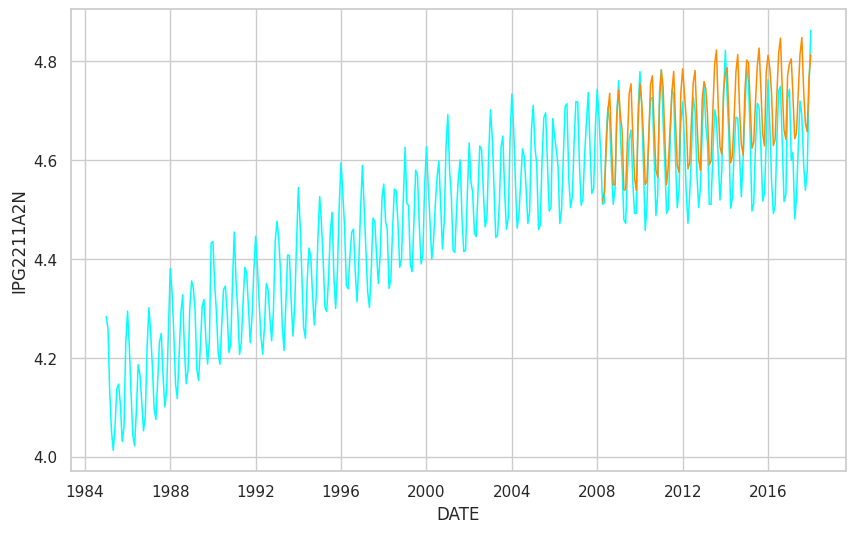

In [ ]:
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred_c', color='darkorange', lw=1.1)

<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

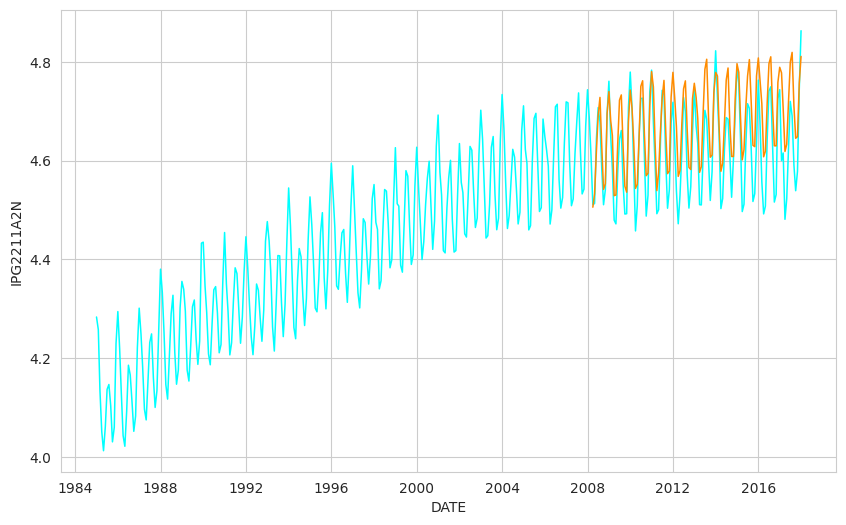

In [ ]:
# final graph
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred_g', color='darkorange', lw=1.1)

<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

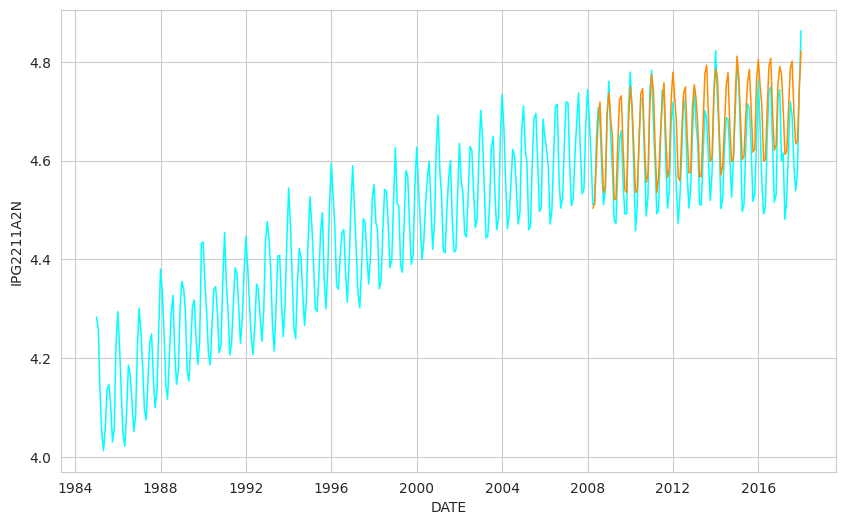

In [ ]:
# final graph
sns.lineplot(data = df_a, x = df_a.index, y = col, color='aqua', lw=1.1)
sns.lineplot(data = df_test, x = df_test.index, y = 'pred_h', color='darkorange', lw=1.1)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
df_test.tail()

,IPG2211A2N,r_mean,r_std,pred_f
DATE,,,,
2017-09-01,4.591227,4.613704,0.090198,4.700086
2017-10-01,4.539177,4.615619,0.088161,4.635199
2017-11-01,4.578168,4.619515,0.085080,4.644531
2017-12-01,4.742505,4.620945,0.087140,4.750578
2018-01-01,4.862945,4.630888,0.106964,4.833087


In [ ]:
mse = mean_squared_error(df_test[col], df_test['pred_h'])
mse

0.004284511991662467

In [ ]:
np.sqrt(mean_squared_error(df_test[col], df_test['pred_h']))  #  order=(4,1,3), seasonal_order=(10,0,12,12) error = 0.06545618375419138
                                                              # order=(2,1,3), seasonal_order=(11,0,12,12)  error = 0.08586147345559415
                                                              #  order=(4,1,4), seasonal_order=(7,0,12,12)  error = 0.0870196400025415
                                                              # order=(4,1,3)   seasonal_order = (6, 0, 12,12) error = 0.0857156811054984
                                                              # order=(4,1,3), seasonal_order=(11,0,12,12) error = 0.06554779036705585
                                                                                              #  (7, 0, 12, 12)  = 0.07192878440460916

0.06545618375419138

In [ ]:
df_test.to_csv(folder_path+'/test_res.csv', index=False)

In [ ]:
futureDate = pd.DataFrame(pd.date_range(start='2018-02-01', end='2021-01-01', freq='MS'), columns=['Dates'])
futureDate.set_index('Dates', inplace=True)

<Axes: >

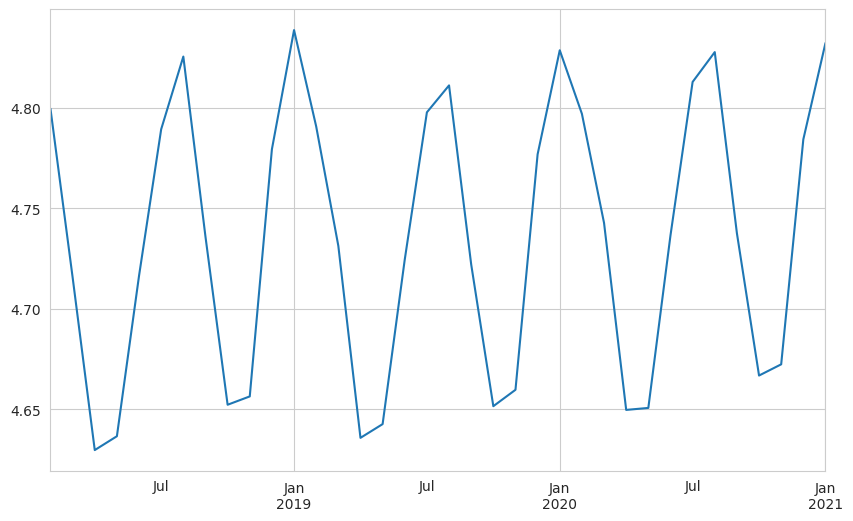

In [ ]:
# add above
results.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot()

In [ ]:
future_df=pd.concat([df,futureDate])
future_df['forecast'] = results.predict(start='2018-02-01', end='2021-01-01', dynamic= True)

<Axes: ylabel='IPG2211A2N'>

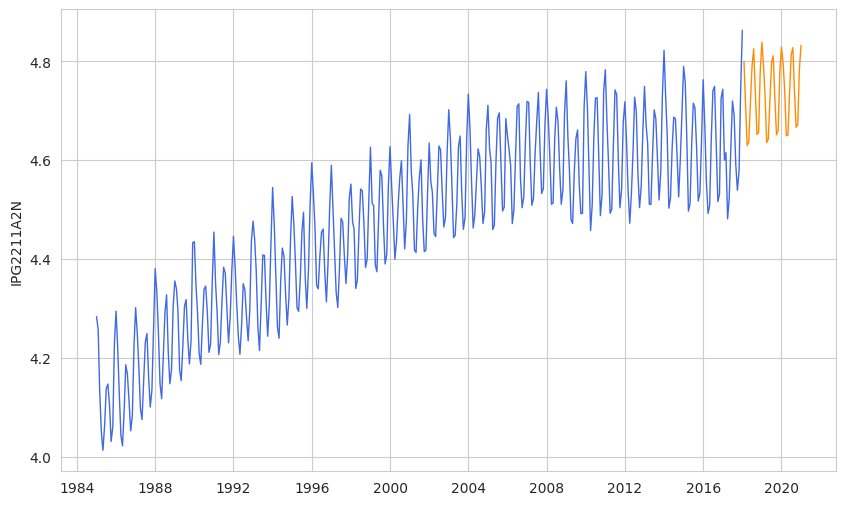

In [ ]:
sns.lineplot(data = future_df, x = future_df.index, y = col, color='', lw=1)
sns.lineplot(data = future_df, x = future_df.index, y = future_df['forecast'], color='darkorange', lw=1)

https://www.kaggle.com/code/nholloway/seasonality-and-sarimax/notebook

https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

https://github.com/alod83/data-science/blob/master/DataAnalysis/SARIMA.ipynb

References:
https://www.kaggle.com/code/satishgunjal/tutorial-time-series-analysis-and-forecasting/notebook

https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb

To be continued.

In [ ]:
results

In [ ]:
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 0.035


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                         SARIMAX Results                                                         
=================================================================================================================================
Dep. Variable:                                                                IPG2211A2N   No. Observations:                  278
Model:             SARIMAX(4, 1, 3)x(10, 0, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 12)   Log Likelihood                 631.839
Date:                                                                   Fri, 16 Jun 2023   AIC                          -1203.677
Time:                                                                           11:56:53   BIC                          -1094.957
Sample:                                                                       01-01-1985   HQIC                         -1160.055
                                                                            - 02-01-2008                                         
Covariance Type:                                                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2103      0.249      0.846      0.398      -0.277       0.698
ar.L2         -0.5194      0.225     -2.305      0.021      -0.961      -0.078
ar.L3         -0.4473      0.213     -2.096      0.036      -0.865      -0.029
ar.L4         -0.3050      0.082     -3.707      0.000      -0.466      -0.144
ma.L1         -0.4659      0.248     -1.882      0.060      -0.951       0.019
ma.L2          0.3819      0.272      1.407      0.160      -0.150       0.914
ma.L3          0.4637      0.231      2.007      0.045       0.011       0.917
ar.S.L12       0.0125      3.029      0.004      0.997      -5.925       5.950
ar.S.L24      -0.0059      2.084     -0.003      0.998      -4.090       4.078
ar.S.L36       0.0024      2.627      0.001      0.999      -5.147       5.152
ar.S.L48       0.1310      2.697      0.049      0.961      -5.155       5.417
ar.S.L60       0.0954      2.637      0.036      0.971      -5.073       5.264
ar.S.L72       0.0761      2.011      0.038      0.970      -3.866       4.018
ar.S.L84       0.1681      2.439      0.069      0.945      -4.612       4.949
ar.S.L96       0.2523      3.310      0.076      0.939      -6.235       6.739
ar.S.L108     -0.0080      2.574     -0.003      0.998      -5.052       5.036
ar.S.L120      0.1263      1.808      0.070      0.944      -3.417       3.670
ma.S.L12       0.3107      3.015      0.103      0.918      -5.598       6.219
ma.S.L24       0.1503      2.794      0.054      0.957      -5.325       5.626
ma.S.L36       0.1853      3.510      0.053      0.958      -6.694       7.065
ma.S.L48       0.2030      3.856      0.053      0.958      -7.354       7.760
ma.S.L60       0.0667      4.154      0.016      0.987      -8.074       8.208
ma.S.L72       0.0687      2.822      0.024      0.981      -5.463       5.601
ma.S.L84       0.1263      1.815      0.070      0.944      -3.431       3.683
ma.S.L96       0.0240      1.431      0.017      0.987      -2.781       2.829
ma.S.L108     -0.1859      1.276     -0.146      0.884      -2.688       2.316
ma.S.L120     -0.0193      1.646     -0.012      0.991      -3.245       3.206
ma.S.L132      0.2492      0.800      0.311      0.755      -1.319       1.817
ma.S.L144     -0.1683      1.064     -0.158      0.874      -2.254       1.917
sigma2         0.0005   9.95e-05      5.053      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                13.78
Prob(Q)

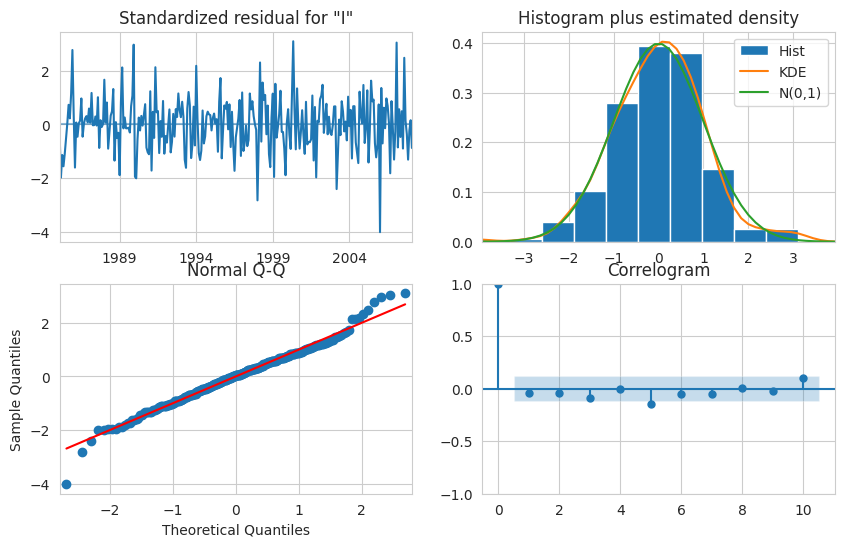

In [ ]:
# Create the 4 diagostics plots using plot_diagnostics method
results.plot_diagnostics()
plt.show()

In [ ]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(df_test['pred_h'], df_test[col])/(np.max(df_test[col])-np.min(df_test[col]))
nrmse

0.1615739776646041

In [ ]:
import joblib

# Set model name
filename = folder_path + "/model.pkl"

# Pickle it
joblib.dump(results,filename)

['/content/drive/MyDrive/ETE_projects/time_series//model.pkl']

<pre>
predictions_diff_cumsum = pred.cumsum()
predictions_diff_cumsum.head()
predictions_log = pd.Series(df_test[col].iloc[0], index=df_test.index) # Series of base number
predictions_log = predictions_log.add(predictions_diff_cumsum,fill_value=0)
predictions_log.head()
predictions = np.exp(predictions_log)
</pre>
https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/